## Part 1: Prediction of drug response using machine learning method

In [1]:
import numpy as np 
import biom
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#load species abundance 

df_species=pd.read_csv('./data/metaphlan2_species_level_abundance_classified.csv',index_col=0)
df_meta=pd.read_csv('./data/metadata_updated_filtered_201904.csv',index_col=0)

#create dictionary to 
dic_date=dict(zip(list(df_meta.index),list(df_meta.time_point)))
dic_surgery=dict(zip(list(df_meta.index),list(df_meta.surgery_type)))

#load alpha diveristy of all samples 
df_alpha=pd.read_csv('./data/Alpha_diversity_faith.csv',index_col=0,header=None)


In [3]:
## only train the model on bacteria 

species_keep=[]
for i in df_species.index: 
    if not 'virus' in i and not 'Archaea'in i:
        species_keep.append(i)
df_species=df_species.loc[species_keep]     
df_species.shape

(428, 301)

## Prediction of anti-TNF response
If we do not separate surgery from non-surgery samples, AUC-ROC is only ~0.58
After adding in a covariate to account for surgery, AUC-ROC is still around ~0.6

In [4]:
## TNF responder 
tnfSamples=[]
for i in range(len(df_meta)):
    row=df_meta.iloc[i]
    if row.tnf_responder!= 'not applicable': 
        if row.name in df_species.columns:
            tnfSamples.append(row.name)
dic_tnf=dict(zip(list(tnfSamples),list(df_meta.tnf_responder.loc[tnfSamples])))

#split samples into surgery vs non-surgery samples 
surgery_tnf=[]
for c in tnfSamples: 
    if dic_surgery[c]!='none': 
        surgery_tnf.append(c)
nonsurgery_tnf=[i for i in tnfSamples if i not in surgery_tnf]

#split species abundance by surgery status 
df_tnf_surgery=df_species[surgery_tnf]
print df_tnf_surgery.shape
df_tnf_non=df_species[nonsurgery_tnf]
print df_tnf_non.shape

(428, 80)
(428, 143)


### First compare the alpha diveristy of gut microbiome of these two groups 

In [5]:
# extract the alpha diversity for groups that has anti-tnf response 
tnfresp=[i for i in dic_tnf.keys() if dic_tnf[i]=='y']
no_tnfresp=[i for i in dic_tnf.keys() if dic_tnf[i]=='n']

alpha_tnfresp=df_alpha.loc[tnfresp]
alpha_no_tnfresp=df_alpha.loc[no_tnfresp]

alpha_tnfresp.shape

(188, 1)

In [6]:
# test if alpha diversity is really different for these two groups 
from scipy.stats import mannwhitneyu
print mannwhitneyu(alpha_no_tnfresp.values,alpha_tnfresp.values)

MannwhitneyuResult(statistic=3176.0, pvalue=0.37301177210214753)


### Prediction starts here

### Split approach: Separates by subjects
make sure subject in training data does not overlap with subjects in test data

In [7]:
### Split approach 2: Separates by subjects
# Create a lists of subject that have done surgery, and subjects that have not done surgery 
dic_subject_tnf=dict(zip(list(df_meta.host_id),list(df_meta.tnf_responder)))
dic_sample_host=dict(zip(list(df_meta.index),list(df_meta.host_id)))
subject_tnf=[i for i in dic_subject_tnf.keys() if dic_subject_tnf[i]=='y']
subject_tnf_non=[i for i in dic_subject_tnf.keys() if dic_subject_tnf[i]=='n']
subject_tnf_info=subject_tnf+subject_tnf
print len(subject_tnf)
print len(subject_tnf_non)


#use randome sample to select ~70% subject from each group as training data 
from random import sample 
sub_train_tnf_non=sample(subject_tnf_non,int(len(subject_tnf_non)*0.7))
sub_train_tnf=sample(subject_tnf,int(len(subject_tnf)*0.7))
sub_train=sub_train_tnf_non+sub_train_tnf


#map subjects back to samples and build the training dataset 
sample_train=[i for i in tnfSamples if dic_sample_host[i] in sub_train]
sample_test=[i for i in tnfSamples if i not in sample_train]
X_train_tnf=df_species[sample_train]
X_test_tnf=df_species[sample_test]


78
17


In [8]:
## create the output for both testing and traning dataset
y_train_tnf=[]
for i in X_train_tnf.columns: 
    if dic_tnf[i]=='n': 
        y_train_tnf.append(0)
    else: 
        y_train_tnf.append(1)


y_test_tnf=[]
for i in X_test_tnf.columns: 
    if dic_tnf[i]=='n': 
        y_test_tnf.append(0)
    else: 
        y_test_tnf.append(1)

In [12]:
#train regressor and run it on test data 
from sklearn.ensemble import RandomForestClassifier

class_rf = RandomForestClassifier(n_jobs=4)
class_rf.fit(X_train_tnf.T, y_train_tnf)

# 10-fold cross validation on the test data 
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(class_rf, X_train_tnf.T, y_train_tnf, cv=10)
print 'cross-validation on the training data: '
print scores

# Predict on new data
y_rf_tnf = class_rf.predict(X_test_tnf.T)


# calculate the accuracy score of the classifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

print 'Prediction accuracy score on the test data: ', accuracy_score(y_test_tnf, y_rf_tnf) 
average_precision=average_precision_score(y_test_tnf, y_rf_tnf) 
print 'Average precision-recall score: ', average_precision

cross-validation on the training data: 
[0.8125     0.86666667 0.73333333 0.86666667 0.86666667 0.86666667
 0.85714286 0.85714286 0.85714286 0.85714286]
Prediction accuracy score on the test data:  0.7894736842105263
Average precision-recall score:  0.9024342678841831


### Precision-recall curve

Text(0.5,1,'Precision-Recall curve: AP=0.90')

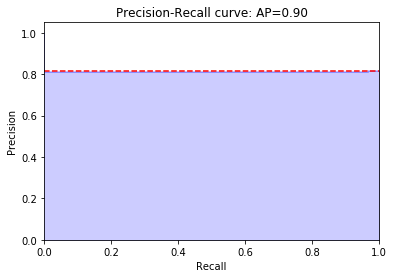

In [14]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test_tnf, y_rf_tnf)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.3,
         where='post')

#plot the baseline
perc=float(y_test_tnf.count(1))/len(y_test_tnf)
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.axhline(y=perc, color='r', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

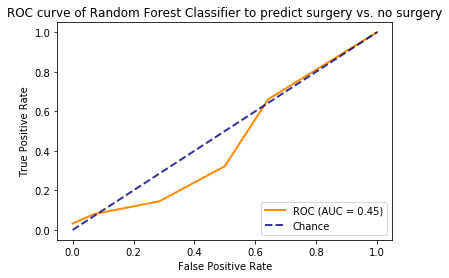

In [15]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area the curve
probas_= class_rf.fit(X_train_tnf.T, y_train_tnf).predict_proba(X_test_tnf.T)

fpr, tpr, thresholds = roc_curve(y_test_tnf, probas_[:, 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2,color='darkorange',
      label='ROC (AUC = %0.2f)' % ( roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
         label='Chance', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Random Forest Classifier to predict surgery vs. no surgery')
plt.legend(loc="lower right")
plt.show()

## Prediction of vedolizumab response

After adding a covariate of surgery status, the ROC-auc is still ~0.58

In [16]:
# vedolizumab_responder
vdzSamples=[]
for i in range(len(df_meta)):
    row=df_meta.iloc[i]
    if row.vedolizumab_responder!= 'not applicable': 
        if row.name in df_species.columns:
            vdzSamples.append(row.name)

#extract abundance profile of samples with vedolizumab response
df_species_vds=df_species[vdzSamples]
dic_vdz=dict(zip(list(vdzSamples),list(df_meta.vedolizumab_responder.loc[vdzSamples])))

#add covariate of surgery status 
surgery_vdz=[]
for s in vdzSamples: 
    if dic_surgery[s]=='none': 
        surgery_vdz.append(0)
    else: 
        surgery_vdz.append(1)
df_species_vds.loc['surgery']=surgery_vdz


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### First compare the alpha diveristy of gut microbiome of these two groups 

In [17]:
# extract the alpha diversity for groups that has anti-tnf response 
vdzresp=[i for i in dic_vdz.keys() if dic_vdz[i]=='y']
no_vdzresp=[i for i in dic_vdz.keys() if dic_vdz[i]=='n']

alpha_vdzresp=df_alpha.loc[vdzresp]
alpha_no_vdzresp=df_alpha.loc[no_vdzresp]

alpha_no_vdzresp.shape

(27, 1)

In [18]:
# test if alpha diversity is really different for these two groups 
from scipy.stats import mannwhitneyu
print mannwhitneyu(alpha_no_vdzresp.values,alpha_vdzresp.values)


MannwhitneyuResult(statistic=561.5, pvalue=0.023419787128030976)


Text(0,0.5,'alpha diversity (Faith)')

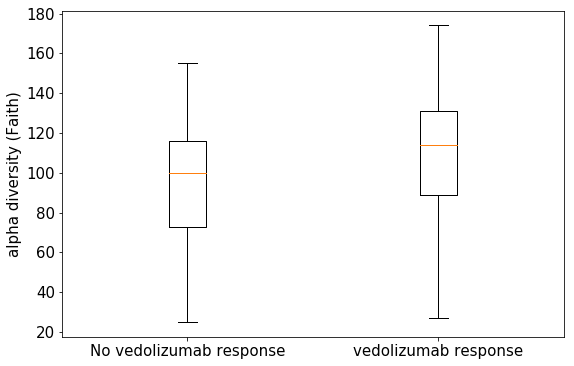

In [19]:
## plot faith alpha diversity for these  different groups 

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[alpha_no_vdzresp.values,alpha_vdzresp.values]
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp=ax.boxplot(data_to_plot) 
ax.set_xticklabels(['No vedolizumab response', 'vedolizumab response'])
ax.set_ylabel('alpha diversity (Faith)')

### Prediction starts here

### Split approach : Separates by subjects
make sure subject in training data does not overlap with subjects in test data

In [20]:
### Split approach 2: Separates by subjects
# Create a lists of subject that have done surgery, and subjects that have not done surgery 
dic_subject_vdz=dict(zip(list(df_meta.host_id),list(df_meta.vedolizumab_responder)))
dic_sample_host=dict(zip(list(df_meta.index),list(df_meta.host_id)))
subject_vdz=[i for i in dic_subject_vdz.keys() if dic_subject_vdz[i]=='y']
subject_vdz_non=[i for i in dic_subject_vdz.keys() if dic_subject_vdz[i]=='n']
subject_vdz_info=subject_vdz+subject_vdz
print len(subject_vdz)
print len(subject_vdz_non)


#use randome sample to select ~70% subject from each group as training data 
from random import sample 
sub_train_vdz_non=sample(subject_vdz_non,int(len(subject_vdz_non)*0.7))
sub_train_vdz=sample(subject_vdz,int(len(subject_vdz)*0.7))
sub_train_all_vdz=sub_train_vdz_non+sub_train_vdz


#map subjects back to samples and build the training dataset 
sample_train=[i for i in vdzSamples if dic_sample_host[i] in sub_train_all_vdz]
sample_test=[i for i in vdzSamples if i not in sample_train]
X_train_vdz=df_species[sample_train]
X_test_vdz=df_species[sample_test]
print (X_train_vdz.shape)
print (X_test_vdz.shape)

23
11
(428, 51)
(428, 33)


In [21]:
## create the output for both testing and traning dataset
y_train_vdz=[]
for i in X_train_vdz.columns: 
    if dic_vdz[i]=='n': 
        y_train_vdz.append(0)
    else: 
        y_train_vdz.append(1)


y_test_vdz=[]
for i in X_test_vdz.columns: 
    if dic_vdz[i]=='n': 
        y_test_vdz.append(0)
    else: 
        y_test_vdz.append(1)

In [22]:
#train regressor and run it on test data 
from sklearn.ensemble import RandomForestClassifier
class_rf = RandomForestClassifier(n_jobs=4)
class_rf.fit(X_train_vdz.T, y_train_vdz)

# 10-fold cross validation on the test data 
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(class_rf, X_train_vdz.T, y_train_vdz, cv=10)
print 'cross-validation on the training data: '
print scores

# Predict on new data
y_rf_vdz = class_rf.predict(X_test_vdz.T)

# calculate the accuracy score of the classifier 
from sklearn.metrics import accuracy_score
print 'Prediction accuracy score on the test data: ', accuracy_score(y_test_vdz, y_rf_vdz) 

cross-validation on the training data: 
[0.66666667 0.66666667 0.83333333 0.83333333 0.8        0.6
 0.6        0.5        0.75       1.        ]
Prediction accuracy score on the test data:  0.5454545454545454


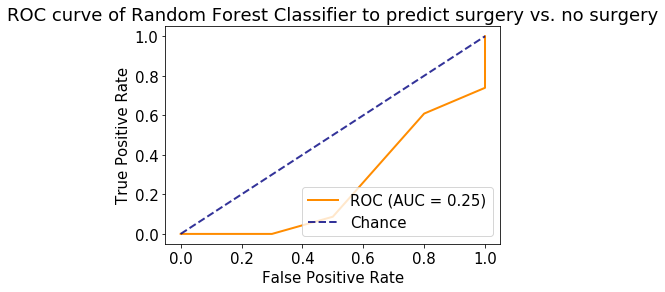

In [23]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area the curve
probas_= class_rf.fit(X_train_vdz.T, y_train_vdz).predict_proba(X_test_vdz.T)

fpr, tpr, thresholds = roc_curve(y_test_vdz, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2,color='darkorange',
      label='ROC (AUC = %0.2f)' % ( roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
         label='Chance', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Random Forest Classifier to predict surgery vs. no surgery')
plt.legend(loc="lower right")
plt.show()

### Precision-recall curve

Text(0.5,1,'Precision-Recall curve: AP=0.90')

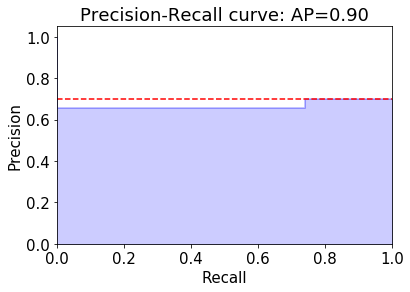

In [24]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test_vdz, y_rf_vdz)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.3,
         where='post')

#plot the baseline
perc=float(y_test_vdz.count(1))/len(y_test_vdz)
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.axhline(y=perc, color='r', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## Prediction of subsequent surgery outcome

Both before/after adding covariate of surgery status, the AUC-ROC is aroun 0.65 

In [25]:
## samples with surgery outcome
sample_outcome=[]
for i in range(len(df_meta)):
    row=df_meta.iloc[i]
    if row.subsequent_surgery!= 'not provided': 
        if row.name in df_species.columns:
            sample_outcome.append(row.name)

#extract abundance profile of samples with vedolizumab response
df_species_outcome=df_species[sample_outcome]
dic_outcome=dict(zip(list(sample_outcome),list(df_meta.subsequent_surgery.loc[sample_outcome])))

#add covariate of surgery status 
surgery_outcome=[]
for s in sample_outcome: 
    if dic_surgery[s]=='none': 
        surgery_outcome.append(0)
    else: 
        surgery_outcome.append(1)
#df_species_outcome.loc['surgery']=surgery_outcome
df_species_outcome.shape

(428, 301)

### First compare the alpha diveristy of gut microbiome of these two groups 

In [26]:
# extract the alpha diversity for groups that has anti-tnf response 
moreSurg=[i for i in dic_outcome.keys() if dic_outcome[i]=='y']
no_moreSurg=[i for i in dic_outcome.keys() if dic_outcome[i]=='n']

alpha_moreSurg=df_alpha.loc[moreSurg]
alpha_no_moreSurg=df_alpha.loc[no_moreSurg]

alpha_moreSurg.shape

(26, 1)

In [27]:
# test if alpha diversity is really different for these two groups 
from scipy.stats import mannwhitneyu
print mannwhitneyu(alpha_no_moreSurg.values,alpha_moreSurg.values)


MannwhitneyuResult(statistic=3385.0, pvalue=0.34894353576832865)


### Prediction starts here 

### Split approach : Separates by subjects
make sure subject in training data does not overlap with subjects in test data

In [28]:
### Split approach 2: Separates by subjects
# Create a lists of subject that have done surgery, and subjects that have not done surgery 
dic_subject_outcome=dict(zip(list(df_meta.host_id),list(df_meta.subsequent_surgery)))
dic_sample_host=dict(zip(list(df_meta.index),list(df_meta.host_id)))
subject_outcome=[i for i in dic_subject_outcome.keys() if dic_subject_outcome[i]=='y']
subject_outcome_non=[i for i in dic_subject_outcome.keys() if dic_subject_outcome[i]=='n']
subject_outcome_info=subject_outcome+subject_outcome
print len(subject_vdz)
print len(subject_vdz_non)


#use randome sample to select ~70% subject from each group as training data 
from random import sample 
sub_train_outcome_non=sample(subject_outcome_non,int(len(subject_outcome_non)*0.7))
sub_train_outcome=sample(subject_outcome,int(len(subject_outcome)*0.7))
sub_train_all_outcome=sub_train_outcome_non+sub_train_outcome


#map subjects back to samples and build the training dataset 
sample_train=[i for i in df_species_outcome.columns if dic_sample_host[i] in sub_train_all_outcome]
sample_test=[i for i in df_species_outcome.columns if i not in sample_train]
X_train_outcome=df_species[sample_train]
X_test_outcome=df_species[sample_test]
print (X_train_outcome.shape)
print (X_test_outcome.shape)

23
11
(428, 213)
(428, 88)


In [29]:
## create the output for both testing and traning dataset

y_train_outcome=[]
for i in X_train_outcome.columns: 
    if dic_outcome[i]=='n': 
        y_train_outcome.append(0)
    else: 
        y_train_outcome.append(1)


y_test_outcome=[]
for i in X_test_outcome.columns: 
    if dic_outcome[i]=='n': 
        y_test_outcome.append(0)
    else: 
        y_test_outcome.append(1)

In [30]:
#train regressor and run it on test data 
from sklearn.ensemble import RandomForestClassifier
class_rf = RandomForestClassifier(n_jobs=4)
class_rf.fit(X_train_outcome.T, y_train_outcome)

# 10-fold cross validation on the test data 
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(class_rf, X_train_outcome.T, y_train_outcome, cv=10)
print 'cross-validation on the training data: '
print scores

# Predict on new data
y_rf_outcome = class_rf.predict(X_test_outcome.T)

# calculate the accuracy score of the classifier 
from sklearn.metrics import accuracy_score
print 'Prediction accuracy score on the test data: ', accuracy_score(y_test_outcome, y_rf_outcome) 

cross-validation on the training data: 
[0.90909091 0.90909091 0.90909091 0.90909091 0.9047619  0.9047619
 0.9047619  0.9047619  0.9047619  0.95      ]
Prediction accuracy score on the test data:  0.8977272727272727


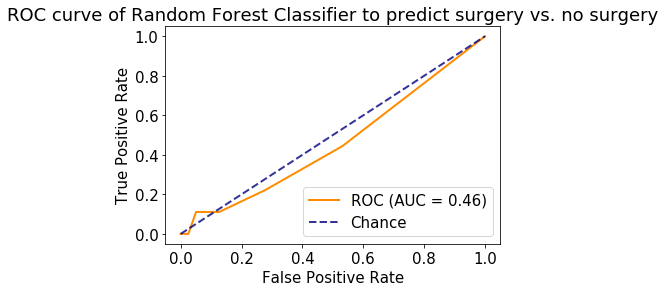

In [31]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area the curve
probas_= class_rf.fit(X_train_outcome.T, y_train_outcome).predict_proba(X_test_outcome.T)

fpr, tpr, thresholds = roc_curve(y_test_outcome, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2,color='darkorange',
      label='ROC (AUC = %0.2f)' % ( roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
         label='Chance', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Random Forest Classifier to predict surgery vs. no surgery')
plt.legend(loc="lower right")
plt.show()

### Precision-recall curve

Text(0.5,1,'Precision-Recall curve: AP=0.90')

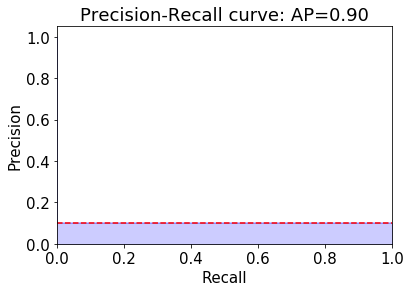

In [32]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test_outcome, y_rf_outcome)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.3,
         where='post')

#plot the baseline
perc=float(y_test_outcome.count(1))/len(y_test_outcome)
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.axhline(y=perc, color='r', linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))